# Compiling Stable Diffusion Base 2.1 for Inf2 and deploy on sagemaker endpoint
### Deploy Stable Diffusion Models using inf2

<!-- 1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
3. [Create model and deploy](#creation-of-the-djl-model-and-deployment-to-sagemaker-endpoint)
5. [Test endpoint](#testing-the-endpoint)
6. [Unpacking and uploading to s3](#unpacking-the-model-and-uploading-it-to-aws-s3)
7. [Conclusion](#conclusion) -->


## Introduction

Welcome to our SageMaker endpoint example, where we will be compiling and deploying the Stable Diffusion 2.1 base model using `neuron-x`.

In this notebook, we will start by compiling the Stable Diffusion model with `neuron-x`. Once compiled, we will store the compiled model on Amazon S3 so that it can be accessed without the need for recompilation in the future. 

Next, we will create a custom inference script that leverages the compiled model for performing inference. This script will enable us replace the components of the original stable diffusion model with the neuron-x compiled components.

Finally, we will deploy the compiled model on a SageMaker endpoint, allowing us to make predictions using the deployed model.

It's important to note that the notebook was executed on an `inf2.8xlarge` instance for the model compilation process. However, once compiled, the model can be run on an `inf2.xlarge` instance, providing the desired functionality and performance.

# Development Environment and Permissions



## Installing Required Libraries

In [1]:
%pip install -U sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.5/857.5 kB 38.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.1/670.1 kB 36.9 MB/s eta 0:00:00
  Created wheel for sagemaker: filename=sagemaker-2.177.0-py2.py3-none-any.whl size=1165853 sha256=703ee5ec0b1efa6e2ba18d73a469b15e5cb394392afee4043266b4f112c8f766
  Stored in directory: /home/ec2-user/.cache/pip/wheels/91/81/8d/b131962bc999764770d56978ad8d1c002a08618e7cca976ce6
Successfully built sagemaker
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.167.0
    Uninstalling sagemaker-2.167.0:
      Successfully uninstalled sagemaker-2.167.0
ERROR: pip's dependency resolver does not currently take into account all the pack

## Permissions
If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker.


In [ ]:
import sagemaker
import boto3
import os
from sagemaker.djl_inference import DJLModel

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

# Replace this with your own model
local_model = "https://sagemaker-us-west-2-xxxxxxxx.s3.us-west-2.amazonaws.com/stable/infer-prepack-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz"
# Or use the external model from jumpstart
extern_model = "s3://jumpstart-cache-prod-us-west-2/stabilityai-infer/prepack/v1.0.0/infer-prepack-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz"


# Check if the "code" directory exists, and create it if it doesn't
code_dir = "code"
if not os.path.exists(code_dir):
    os.makedirs(code_dir)

In [ ]:
import os
os.environ["NEURON_FUSE_SOFTMAX"] = "1"

import torch
import torch.nn as nn
import torch_neuronx
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import time
import copy
from IPython.display import clear_output

from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.models.unet_2d_condition import UNet2DConditionOutput
from diffusers.models.cross_attention import CrossAttention

clear_output(wait=False)


In [2]:
%%writefile code/wrapper.py
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

import torch
import torch.nn as nn
from diffusers.models.unet_2d_condition import UNet2DConditionOutput

class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        out_tuple = self.unet(sample, timestep, encoder_hidden_states, return_dict=False)
        return out_tuple

class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
        self.unetwrap = unetwrap
        self.config = unetwrap.unet.config
        self.in_channels = unetwrap.unet.in_channels
        self.device = unetwrap.unet.device
        self.dtype = unetwrap.unet.dtype

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        sample = self.unetwrap(sample, timestep.type(self.dtype).expand((sample.shape[0],)), encoder_hidden_states)[0]
        return UNet2DConditionOutput(sample=sample)

class NeuronTextEncoder(nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.neuron_text_encoder = text_encoder
        self.config = text_encoder.config
        self.dtype = text_encoder.dtype
        self.device = text_encoder.device

    def forward(self, emb, attention_mask = None):
        return [self.neuron_text_encoder(emb)['last_hidden_state']]
    

# Optimized attention
def get_attention_scores(self, query, key, attn_mask):       
    dtype = query.dtype

    if self.upcast_attention:
        query = query.float()
        key = key.float()

    # Check for square matmuls
    if(query.size() == key.size()):
        attention_scores = custom_badbmm(
            key,
            query.transpose(-1, -2)
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=1).permute(0,2,1)
        attention_probs = attention_probs.to(dtype)

    else:
        attention_scores = custom_badbmm(
            query,
            key.transpose(-1, -2)
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = attention_probs.to(dtype)
        
    return attention_probs

def custom_badbmm(a, b):
    bmm = torch.bmm(a, b)
    scaled = bmm * 0.125
    return scaled

Overwriting code/wrapper.py


# Model Compilation

>Currently, we are compiling the model to generate one image at a time. You can change this by modifying input embeddings.

In [8]:
import boto3
import sagemaker
import numpy as np

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

region_trn1='us-east-2'
boto3_sess_trn1 = boto3.Session(region_name=region_trn1) # trn1 session
sess_trn1 = sagemaker.Session(boto3_sess_trn1)

region_inf2='us-east-2'
boto3_sess_inf2 = boto3.Session(region_name=region_inf2) # inf2 session
sess_inf2 = sagemaker.Session(boto3_sess_inf2)

bucket_trn1 = sess_trn1.default_bucket()
bucket_inf2 = sess_inf2.default_bucket()
role = sagemaker.get_execution_role()

# https://github.com/aws/deep-learning-containers/blob/master/available_images.md#neuron-containers
train_image_name="pytorch-compile-neuronx"
inference_image_name="pytorch-inference-neuronx"
# We need SDK2.10+ to deal with SDs
image_tag="1.13.1-neuronx-py38-sdk2.10.0-ubuntu20.04"

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket trn1: {bucket_trn1}")
print(f"sagemaker bucket inf2: {bucket_inf2}")
print(f"sagemaker session regions. trn1: {region_trn1} inf2: {region_inf2}")


2.177.0
sagemaker role arn: arn:aws:iam::709851513305:role/service-role/AmazonSageMaker-ExecutionRole-20230811T211335
sagemaker bucket trn1: sagemaker-us-east-2-709851513305
sagemaker bucket inf2: sagemaker-us-east-2-709851513305
sagemaker session regions. trn1: us-east-2 inf2: us-east-2


In [5]:
%%writefile code/compile.py
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

import os
os.environ["NEURON_FUSE_SOFTMAX"] = "1"
import time
import copy
import torch
import shutil
import argparse
import numpy as np
import torch_neuronx
import torch.nn as nn

from wrapper import NeuronTextEncoder, UNetWrap, NeuronUNet, get_attention_scores
from diffusers.models.cross_attention import CrossAttention
from diffusers.models.unet_2d_condition import UNet2DConditionOutput
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

def compile_text_encoder(text_encoder, args):
    print("Compiling text encoder...")
    base_dir='text_encoder'
    os.makedirs(os.path.join(args.checkpoints_path, base_dir), exist_ok=True)
    os.makedirs(os.path.join(args.model_path, base_dir), exist_ok=True)
    t = time.time()
    # Apply the wrapper to deal with custom return type
    text_encoder = NeuronTextEncoder(text_encoder)

    # Compile text encoder
    # This is used for indexing a lookup table in torch.nn.Embedding,
    # so using random numbers may give errors (out of range).
    emb = torch.tensor([[49406, 18376,   525,  7496, 49407,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]])
    text_encoder_neuron = torch_neuronx.trace(
        text_encoder.neuron_text_encoder, emb,
        #compiler_workdir=os.path.join(args.checkpoints_path, base_dir),
    )

    # Save the compiled text encoder
    text_encoder_filename = os.path.join(args.model_path, base_dir, 'model.pt')
    torch.jit.save(text_encoder_neuron, text_encoder_filename)

    # delete unused objects
    del text_encoder
    del text_encoder_neuron
    print(f"Done. Elapsed time: {(time.time()-t)*1000}ms")

def compile_vae(decoder, args, dtype):
    print("Compiling VAE...")
    base_dir='vae_decoder'
    os.makedirs(os.path.join(args.checkpoints_path, base_dir), exist_ok=True)
    os.makedirs(os.path.join(args.model_path, base_dir), exist_ok=True)
    t = time.time()
    # Compile vae decoder
    decoder_in = torch.randn([1, 4, 64, 64]).type(dtype)
    decoder_neuron = torch_neuronx.trace(
        decoder,
        decoder_in,
        #compiler_workdir=os.path.join(args.checkpoints_path, base_dir),
    )

    # Save the compiled vae decoder
    decoder_filename = os.path.join(args.model_path, base_dir, 'model.pt')
    torch.jit.save(decoder_neuron, decoder_filename)

    # delete unused objects
    del decoder
    del decoder_neuron
    print(f"Done. Elapsed time: {(time.time()-t)*1000}ms")

def compile_unet(unet, args, dtype):
    print("Compiling U-Net...")
    base_dir='unet'
    os.makedirs(os.path.join(args.checkpoints_path, base_dir), exist_ok=True)
    os.makedirs(os.path.join(args.model_path, base_dir), exist_ok=True)
    t = time.time()
    # Compile unet - BF16
    sample_1b = torch.randn([1, 4, 64, 64]).type(dtype)
    timestep_1b = torch.tensor(999).type(dtype).expand((1,))
    encoder_hidden_states_1b = torch.randn([1, 77, 1024]).type(dtype)
    example_inputs = sample_1b, timestep_1b, encoder_hidden_states_1b

    unet_neuron = torch_neuronx.trace(
        unet,
        example_inputs,
        #compiler_workdir=os.path.join(args.checkpoints_path, base_dir),
        compiler_args=["--model-type=unet-inference"]
    )

    # save compiled unet
    unet_filename = os.path.join(args.model_path, base_dir, 'model.pt')
    torch.jit.save(unet_neuron, unet_filename)

    # delete unused objects
    del unet
    del unet_neuron
    print(f"Done. Elapsed time: {(time.time()-t)*1000}ms")

def compile_vae_post_quant_conv(post_quant_conv, args, dtype):
    print("Compiling Post Quant Conv...")
    base_dir='vae_post_quant_conv'
    os.makedirs(os.path.join(args.checkpoints_path, base_dir), exist_ok=True)
    os.makedirs(os.path.join(args.model_path, base_dir), exist_ok=True)
    t = time.time()

    # # Compile vae post_quant_conv
    post_quant_conv_in = torch.randn([1, 4, 64, 64]).type(dtype)
    post_quant_conv_neuron = torch_neuronx.trace(
        post_quant_conv,
        post_quant_conv_in,
        #compiler_workdir=os.path.join(args.checkpoints_path, base_dir),
    )

    # # Save the compiled vae post_quant_conv
    post_quant_conv_filename = os.path.join(args.model_path, base_dir, 'model.pt')
    torch.jit.save(post_quant_conv_neuron, post_quant_conv_filename)

    # delete unused objects
    del post_quant_conv
    del post_quant_conv_neuron
    print(f"Done. Elapsed time: {(time.time()-t)*1000}ms")

if __name__=='__main__':
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--model-path', type=str, help="Path where we'll save the model", default=os.environ["SM_MODEL_DIR"])
    parser.add_argument('--checkpoints-path', type=str, help="Path where we'll save the best model and cache", default='/opt/ml/checkpoints')
    parser.add_argument('--dtype', type=str, choices=['bf16','fp32'], default='bf16', help="Datatype of the weights")

    args = parser.parse_args()

    # make sure the checkpoint path exists
    os.makedirs(args.checkpoints_path, exist_ok=True)

    # Model ID for SD version pipeline
    model_id = "stabilityai/stable-diffusion-2-1-base"

    # --- Compile CLIP text encoder and save ---

    dtype = torch.bfloat16 if args.dtype == 'bf16' else torch.float32
    # Only keep the model being compiled in RAM to minimze memory pressure
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
    text_encoder = copy.deepcopy(pipe.text_encoder)
    del pipe
    compile_text_encoder(text_encoder, args)

    # --- Compile VAE decoder and save ---

    # Only keep the model being compiled in RAM to minimze memory pressure
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
    decoder = copy.deepcopy(pipe.vae.decoder)
    del pipe
    compile_vae(decoder, args, dtype)

    # --- Compile UNet and save ---

    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)

    # Replace original cross-attention module with custom cross-attention module for better performance
    CrossAttention.get_attention_scores = get_attention_scores

    # Apply double wrapper to deal with custom return type
    pipe.unet = NeuronUNet(UNetWrap(pipe.unet))

    # Only keep the model being compiled in RAM to minimze memory pressure
    unet = copy.deepcopy(pipe.unet.unetwrap)
    del pipe
    compile_unet(unet, args, dtype)

    # --- Compile VAE post_quant_conv and save ---

    # Only keep the model being compiled in RAM to minimze memory pressure
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
    post_quant_conv = copy.deepcopy(pipe.vae.post_quant_conv)
    del pipe
    compile_vae_post_quant_conv(post_quant_conv, args, dtype)

    code_path = os.path.join(args.model_path, 'code')
    os.makedirs(code_path, exist_ok=True)
    
    # replace datatype
    with open('inference.py', 'r') as f:
        data = f.read()
    data = data.replace('DTYPE_REPLACE', 'torch.bfloat16' if args.dtype=='bf16' else 'torch.float32')
    with open('inference.py', 'w') as f:
        f.write(data)

    shutil.copyfile('inference.py', os.path.join(code_path, 'inference.py'))
    shutil.copyfile('wrapper.py', os.path.join(code_path, 'wrapper.py'))
    shutil.copyfile('requirements.txt', os.path.join(code_path, 'requirements.txt'))


Overwriting code/compile.py


In [9]:
region_trn1

'us-east-2'

In [12]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="compile.py", # Specify your train script
    source_dir="code",
    image_uri=f"763104351884.dkr.ecr.{region_trn1}.amazonaws.com/{train_image_name}:{image_tag}",
    role=role,
    sagemaker_session=sess_trn1,
    instance_count=1,
    instance_type='ml.trn1.2xlarge',
    disable_profiler=True,
    output_path=f"s3://{bucket_trn1}/output",    
    volume_size = 384,
    
    # Parameters required to enable checkpointing
    # This is necessary for caching XLA HLO files and reduce training time next time    
    checkpoint_s3_uri=f"s3://{bucket_trn1}/checkpoints",
    hyperparameters={
        "dtype": "bf16" # dtype can also be fp32
    }
)
estimator.framework_version = '1.13.1' # workround when using image_uri
estimator._is_compiled_model = True


In [13]:
estimator.fit()

Using provided s3_resource


INFO:sagemaker:Creating training-job with name: pytorch-compile-neuronx-2023-08-11-19-37-55-064


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The requested resource training-job/ml.trn1.2xlarge is not available in this region

## wrapper classes for neuon-x stable diffusion



In [6]:
class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        out_tuple = self.unet(sample, timestep, encoder_hidden_states, return_dict=False)
        return out_tuple

class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
        self.unetwrap = unetwrap
        self.config = unetwrap.unet.config
        self.in_channels = unetwrap.unet.in_channels
        self.device = unetwrap.unet.device

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        sample = self.unetwrap(sample, timestep.float().expand((sample.shape[0],)), encoder_hidden_states)[0]
        return UNet2DConditionOutput(sample=sample)

class NeuronTextEncoder(nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.neuron_text_encoder = text_encoder
        self.config = text_encoder.config
        self.dtype = text_encoder.dtype
        self.device = text_encoder.device

    def forward(self, emb, attention_mask = None):
        return [self.neuron_text_encoder(emb)['last_hidden_state']]
    

# Optimized attention
def get_attention_scores(self, query, key, attn_mask):       
    dtype = query.dtype

    if self.upcast_attention:
        query = query.float()
        key = key.float()

    # Check for square matmuls
    if(query.size() == key.size()):
        attention_scores = custom_badbmm(
            key,
            query.transpose(-1, -2)
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=1).permute(0,2,1)
        attention_probs = attention_probs.to(dtype)

    else:
        attention_scores = custom_badbmm(
            query,
            key.transpose(-1, -2)
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = attention_probs.to(dtype)
        
    return attention_probs

def custom_badbmm(a, b):
    bmm = torch.bmm(a, b)
    scaled = bmm * 0.125
    return scaled


NameError: name 'nn' is not defined

## Compile

The compilation process of the model may require a few minutes to complete. Please be patient during this compilation phase.

In [ ]:
# For saving compiler artifacts
COMPILER_WORKDIR_ROOT = 'sd2_compile_dir_512'

# Model ID for SD version pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"


# --- Compile CLIP text encoder and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
text_encoder = copy.deepcopy(pipe.text_encoder)
del pipe

# Apply the wrapper to deal with custom return type
text_encoder = NeuronTextEncoder(text_encoder)

# Compile text encoder
# This is used for indexing a lookup table in torch.nn.Embedding,
# so using random numbers may give errors (out of range).
emb = torch.tensor([[49406, 18376,   525,  7496, 49407,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0]])
text_encoder_neuron = torch_neuronx.trace(
        text_encoder.neuron_text_encoder, 
        emb, 
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder'),
        )

# Save the compiled text encoder
text_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder/model.pt')
torch.jit.save(text_encoder_neuron, text_encoder_filename)

# delete unused objects
del text_encoder
del text_encoder_neuron



# --- Compile VAE decoder and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
decoder = copy.deepcopy(pipe.vae.decoder)
del pipe

# Compile vae decoder
decoder_in = torch.randn([1, 4, 64, 64])
decoder_neuron = torch_neuronx.trace(
    decoder, 
    decoder_in, 
    compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder'),
)

# Save the compiled vae decoder
decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder/model.pt')
torch.jit.save(decoder_neuron, decoder_filename)

# delete unused objects
del decoder
del decoder_neuron



# --- Compile UNet and save ---

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

# Replace original cross-attention module with custom cross-attention module for better performance
CrossAttention.get_attention_scores = get_attention_scores

# Apply double wrapper to deal with custom return type
pipe.unet = NeuronUNet(UNetWrap(pipe.unet))

# Only keep the model being compiled in RAM to minimze memory pressure
unet = copy.deepcopy(pipe.unet.unetwrap)
del pipe

# Compile unet - FP32
sample_1b = torch.randn([1, 4, 64, 64])
timestep_1b = torch.tensor(999).float().expand((1,))
encoder_hidden_states_1b = torch.randn([1, 77, 1024])
example_inputs = sample_1b, timestep_1b, encoder_hidden_states_1b

unet_neuron = torch_neuronx.trace(
    unet,
    example_inputs,
    compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'unet'),
    compiler_args=["--model-type=unet-inference"]
)

# save compiled unet
unet_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'unet/model.pt')
torch.jit.save(unet_neuron, unet_filename)

# delete unused objects
del unet
del unet_neuron



# --- Compile VAE post_quant_conv and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
post_quant_conv = copy.deepcopy(pipe.vae.post_quant_conv)
del pipe

# # Compile vae post_quant_conv
post_quant_conv_in = torch.randn([1, 4, 64, 64])
post_quant_conv_neuron = torch_neuronx.trace(
    post_quant_conv, 
    post_quant_conv_in,
    compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'vae_post_quant_conv'),
)

# # Save the compiled vae post_quant_conv
post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_post_quant_conv/model.pt')
torch.jit.save(post_quant_conv_neuron, post_quant_conv_filename)

# delete unused objects
del post_quant_conv
del post_quant_conv_neuron

# Custom Inference Script Creation

### Extension of the Inference Script:
We have enhanced the base inference script to incorporate the loading of the neuron-x compiled stable diffusion components.

In [6]:
%%writefile code/inference.py
import os
os.environ["NEURON_FUSE_SOFTMAX"] = "1"

import torch
import torch.nn as nn
import torch_neuronx
import base64
import torch
from io import BytesIO
import json
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.models.unet_2d_condition import UNet2DConditionOutput

class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        out_tuple = self.unet(sample, timestep, encoder_hidden_states, return_dict=False)
        return out_tuple

class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
        self.unetwrap = unetwrap
        self.config = unetwrap.unet.config
        self.in_channels = unetwrap.unet.in_channels
        self.device = unetwrap.unet.device

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        sample = self.unetwrap(sample, timestep.float().expand((sample.shape[0],)), encoder_hidden_states)[0]
        return UNet2DConditionOutput(sample=sample)

class NeuronTextEncoder(nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.neuron_text_encoder = text_encoder
        self.config = text_encoder.config
        self.dtype = text_encoder.dtype
        self.device = text_encoder.device

    def forward(self, emb, attention_mask = None):
        return [self.neuron_text_encoder(emb)['last_hidden_state']]


# Optimized attention
def get_attention_scores(self, query, key, attn_mask):
    dtype = query.dtype

    if self.upcast_attention:
        query = query.float()
        key = key.float()

    # Check for square matmuls
    if(query.size() == key.size()):
        attention_scores = custom_badbmm(
            key,
            query.transpose(-1, -2)
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=1).permute(0,2,1)
        attention_probs = attention_probs.to(dtype)

    else:
        attention_scores = custom_badbmm(
            query,
            key.transpose(-1, -2)
        )

        if self.upcast_softmax:
            attention_scores = attention_scores.float()

        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = attention_probs.to(dtype)

    return attention_probs

def custom_badbmm(a, b):
    bmm = torch.bmm(a, b)
    scaled = bmm * 0.125
    return scaled


#  -- Rest of sagemaker --
model_id = "stabilityai/stable-diffusion-2-1-base"
dtype = DTYPE_REPLACE

def model_fn(model_dir, context=None):
    global model_id, dtype
    print("Loading model parts...")
    t=time.time()

    text_encoder_filename = os.path.join(model_dir, 'text_encoder/model.pt')
    decoder_filename = os.path.join(model_dir, 'vae_decoder/model.pt')
    unet_filename = os.path.join(model_dir, 'unet/model.pt')
    post_quant_conv_filename = os.path.join(model_dir, 'vae_post_quant_conv/model.pt')

    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

    # Load the compiled UNet onto two neuron cores.
    pipe.unet = NeuronUNet(UNetWrap(pipe.unet))
    pipe.unet.unetwrap = torch_neuronx.DataParallel(torch.jit.load(unet_filename), None, set_dynamic_batching=False)

    # Load other compiled models onto a single neuron core.
    pipe.text_encoder = NeuronTextEncoder(pipe.text_encoder)
    pipe.text_encoder.neuron_text_encoder = torch.jit.load(text_encoder_filename)
    pipe.vae.decoder = torch.jit.load(decoder_filename)
    pipe.vae.post_quant_conv = torch.jit.load(post_quant_conv_filename)

    print(f"Done. Elapsed time: {(time.time()-t)*1000}ms")
    return { "text2image": pipe }


def predict_fn(data, pipe):
    device = 'xla'
    # get prompt & parameters
    prompt = data.pop("inputs", data)
    # set valid HP for stable diffusion
    num_inference_steps = max(min(data.pop("num_inference_steps", 25), 100), 0)
    guidance_scale = data.pop("guidance_scale", 7.5)
    num_images_per_prompt = data.pop("num_images_per_prompt", 1)
    negative_prompt = data.pop("negative_prompt", None)

    width = max(min(data.pop("width", 512), 1024), 64)
    height = max(min(data.pop("height", 512), 1024), 64)
    width = (width // 8) * 8
    height = (height // 8) * 8

    # get mode (text2image, text2vector, image2image)
    mode = data.pop("mode", data)

    seed = data.pop("seed", None)
    latents = []
    seeds = []

    generator = torch.Generator()
    if mode == 'text2image':
        if seed:
            generator.manual_seed(seed)
            latents = torch.randn(
                (1, pipe[mode].unet.in_channels, height // 8, width // 8),
                generator = generator,
                device = device
            )
            latents = [latents]
            #we set the amount of images to 1, otherwise we're generating x times the same image.
            num_images_per_prompt = 1
        else:
            for _ in range(num_images_per_prompt):
                # Get a new random seed, store it and use it as the generator state
                _seed = generator.seed()
                seeds.append(_seed)
                generator = generator.manual_seed(_seed)

                image_latents = torch.randn(
                    (1, pipe[mode].unet.in_channels, height // 8, width // 8),
                    generator = generator,
                    device = device
                )
                latents.append(image_latents)
                # latents = image_latents if latents is None else torch.cat((latents, image_latents))

        # print(latents.shape)
        generated_images = []
        # run generation with parameters
        for counter, _ in enumerate(range(num_images_per_prompt)):
            generated_image = pipe['text2image'](
                prompt=prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                num_images_per_prompt=1,
                negative_prompt=negative_prompt,
                latents = latents[counter]
            )["images"]
            generated_images.append(generated_image[0])

        # create response
        encoded_images = []
        for image in generated_images:
            buffered = BytesIO()
            image.save(buffered, format="JPEG")
            encoded_images.append(base64.b64encode(buffered.getvalue()).decode())

        # create response
        return {"generated_images": encoded_images, "seeds": seeds or [seed]}

    if mode == 'text2vector':
        # tokenize the prompt
        prompt_inputs = pipe['text2image'].tokenizer(
            prompt, return_tensors='pt',
            padding='max_length'
        )['input_ids']
        # create prompt encoding
        
        prompt_embeds = pipe['text2image'].text_encoder.neuron_text_encoder(prompt_inputs)
        # extract CLIP embedding
        prompt_embeds = prompt_embeds['pooler_output']

        prompt_embeds = prompt_embeds.cpu().detach().numpy()

        # Serialize the NumPy array to JSON
        prompt_embeds = json.dumps(prompt_embeds.tolist())

        return {"generated_vector": prompt_embeds}

    return {"error": "specify mode (text2image, or text2vector)"}

Writing code/inference.py


### Extension of the base image:
Since we're using python libraries that are not default in the ECR image we're using, we have to install them using a `requirements.txt` in the `code` folder

In [7]:
%%writefile code/requirements.txt
diffusers==0.11.1 
transformers==4.25.1 
scipy==1.9.3 
accelerate==0.15.0


Writing code/requirements.txt


# Creation of the PytorchModel and deploy



In [ ]:
from sagemaker.pytorch.model import PyTorchModel

deploy_image_uri = '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-inference-neuronx:1.13.1-neuronx-py38-sdk2.10.0-ubuntu20.04'
# create Pytorch Class
diffusion_model = PyTorchModel(
   model_data='s3://sagemaker-us-east-2-xxxxxx/pytorch-inference-neuronx-2023-06-06-19-54-57-615/model.tar.gz',      # path to your model and script
   image_uri=deploy_image_uri,
   entry_point = 'inference.py',
   source_dir = "./code/",
   role=role,                    # iam role with permissions to create an Endpoint
)

# manually set the model as compiled to skip the compiling step.
diffusion_model._is_compiled_model = True


# deploy the endpoint endpoint
predictor = diffusion_model.deploy(
    initial_instance_count=1,
    instance_type="ml.inf2.xlarge",
    volume_size=32, #model artifact is too large
)


# Testing the Endpoint

Please allow a few minutes for the endpoint to become live. Once it's ready, you can test the endpoint using either the predictor object or invoke the endpoint using boto3.

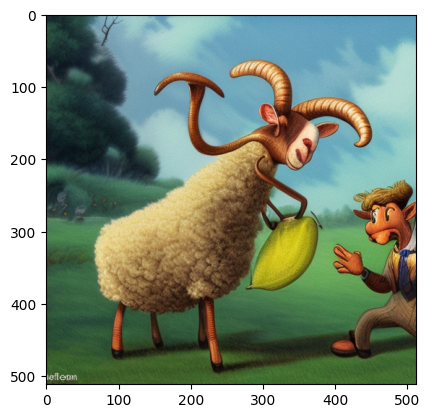

In [122]:
num_images_per_prompt = 3
prompt = "A sheep trying catch a goat art drawn by disney concept artists, yellow colour, high quality, highly detailed, elegant, sharp focus"

# run prediction
response = predictor.predict(data={
  "prompt": prompt
  }
)

from PIL import Image
import io
image_stream = io.BytesIO(response)

# Open the image stream using PIL
image = Image.open(image_stream)

plt.imshow(image)

# Conclusion

Remember to delete your endpoint to ensure that resources are not being unnecessarily consumed.

In [ ]:
# predictor.delete_model()
predictor.delete_endpoint()